In [1]:
import sys
import os.path
import pylab as plt
plt.style.use('dark_background')
#path = '../zedstat/'
#sys.path.append(path)
from zedstat.zedstat import zedstat
import pandas as pd

In [2]:
df=pd.read_csv('examples_data/roc2.csv')
df=df.sort_values('fpr')
#df=df.drop('threshold',axis=1)

In [3]:
zt=zedstat(df=df,
           order=3,
           total_samples=100000,
           positive_samples=1000,
           alpha=0.1,
           prevalence=.01)

In [4]:
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=True)
zt.usample(precision=3)
zt.getBounds()

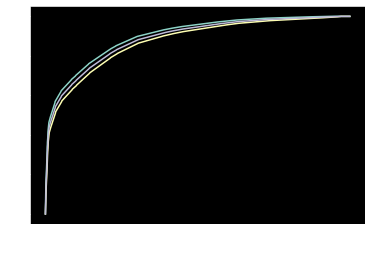

In [5]:
ax=zt.df_lim['U'].tpr.plot()
ax=zt.df_lim['L'].tpr.plot(ax=ax)
ax=zt.get().tpr.plot(ax=ax)

<AxesSubplot:xlabel='LR-'>

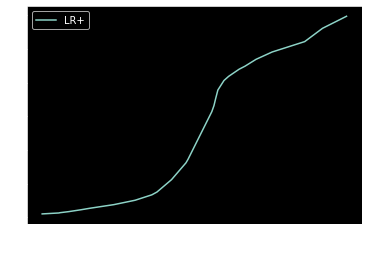

In [6]:
zt.get().plot(x='LR-',y='LR+')

In [9]:
zt.auc(alpha=.1)

(0.8875903790087464, 0.9011943034492365, 0.8738887723569924)

In [24]:
zt.auc_cb2()

In [12]:
# required sample size
zt.samplesize(delta_auc=.1)

26.99420757849582

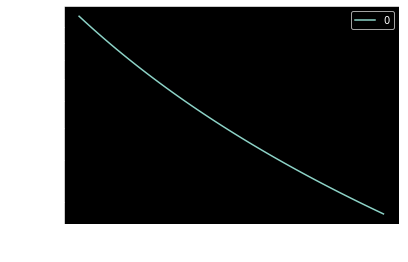

In [13]:
import numpy as np
pd.DataFrame(np.array([zt.samplesize(delta_auc=a) 
                       for a in np.arange(.05,.1,.001)]),
             np.arange(.05,.1,.001)).plot(logy=True)
plt.gca().set_xlabel('delta AUC')
plt.gca().set_ylabel('minimum samples');

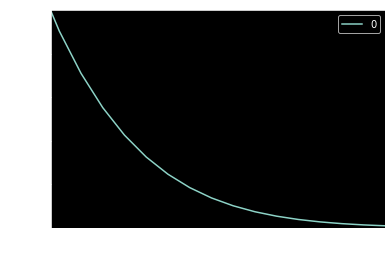

In [14]:
pd.DataFrame([zt.pvalue(delta_auc=a) for a in np.arange(0.001,.1,.001)],
             np.arange(0.001,.1,.001)).plot()
plt.gca().set_ylim(0,0.05)   
plt.gca().set_xlim(0.0196,0.035)   
plt.gca().set_xlabel('delta AUC')
plt.gca().set_ylabel('pvalue');

In [23]:
zt.operating_zone(LRminus=.65)
rf0,txt0=zt.interpret(fpr=zt._operating_zone.fpr.values[0],number_of_positives=10)
rf1,txt1=zt.interpret(fpr=zt._operating_zone.fpr.values[1],number_of_positives=10)
display(zt._operating_zone)
print('high precision operation:\n','\n '.join(txt0))
print('\n')
print('high recall operation:\n','\n '.join(txt1))

,fpr,tpr,ppv,acc,npv,LR+,LR-,threshold
high precision,0.008,0.358115,0.307628,0.985499,0.993506,43.99784,0.647145,0.234186
high sensitivity,0.064,0.616202,0.091559,0.932393,0.995877,10.00695,0.409831,0.031257


high precision operation:
 For every 10 positive instances
 we raise 26 flags,
 out of which 5 are true positives
 21 are false alarms
 5 cases are missed


high recall operation:
 For every 10 positive instances
 we raise 44 flags,
 out of which 6 are true positives
 38 are false alarms
 4 cases are missed
